In [23]:
# coding: utf-8
import numpy as np

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad


In [24]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)


In [25]:
# coding: utf-8
import numpy as np


def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


In [26]:
# coding: utf-8
import numpy as np


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


In [27]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])

        class_label, class_counts = np.unique(t, return_counts = True)
        class_accuracy = np.zeros(np.max(class_label) + 1)

        for i in range(len(class_accuracy)):
            class_accuracy[i] = np.sum((y ==i) & (t == i)) / float(class_counts[i])

        return accuracy, class_accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


In [28]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.abspath('./')
#dataset_dir = os.path.dirname(os.path.abspath(__file__))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
        _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])    
    
    if not flatten:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()


Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


label별 개수:  Counter({2: 2010, 1: 1980, 13: 1920, 12: 1890, 38: 1860, 10: 1800, 4: 1770, 5: 1650, 25: 1350, 9: 1320, 7: 1290, 3: 1260, 8: 1260, 11: 1170, 35: 1080, 18: 1080, 17: 990, 31: 690, 14: 690, 33: 599, 26: 540, 15: 540, 28: 480, 23: 450, 30: 390, 16: 360, 34: 360, 6: 360, 36: 330, 22: 330, 40: 300, 20: 300, 39: 270, 21: 270, 29: 240, 24: 240, 41: 210, 42: 210, 32: 210, 27: 210, 37: 180, 19: 180, 0: 180})
0 0.024209957580843555 0.009105304829770388
1 0.026440124613456874 0.046239113222486146
2 0.023382266723378817 0.057007125890736345
3 0.024669785834990632 0.05692794932699921
4 0.023255813953488372 0.057007125890736345
5 0.023255813953488372 0.057007125890736345
6 0.023278805366195726 0.057007125890736345
7 0.025462989573394337 0.031828978622327794
8 0.0532021290048167 0.028503562945368172
9 0.04249962638954351 0.06801266825019794
10 0.06726137787536356 0.03507521773555028
11 0.03739553276851096 0.060174188440221696
12 0.08091827702353172 0.12794932699920825
13 0.101150720206003

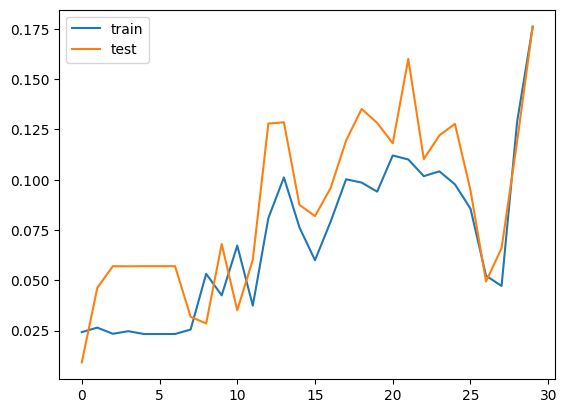

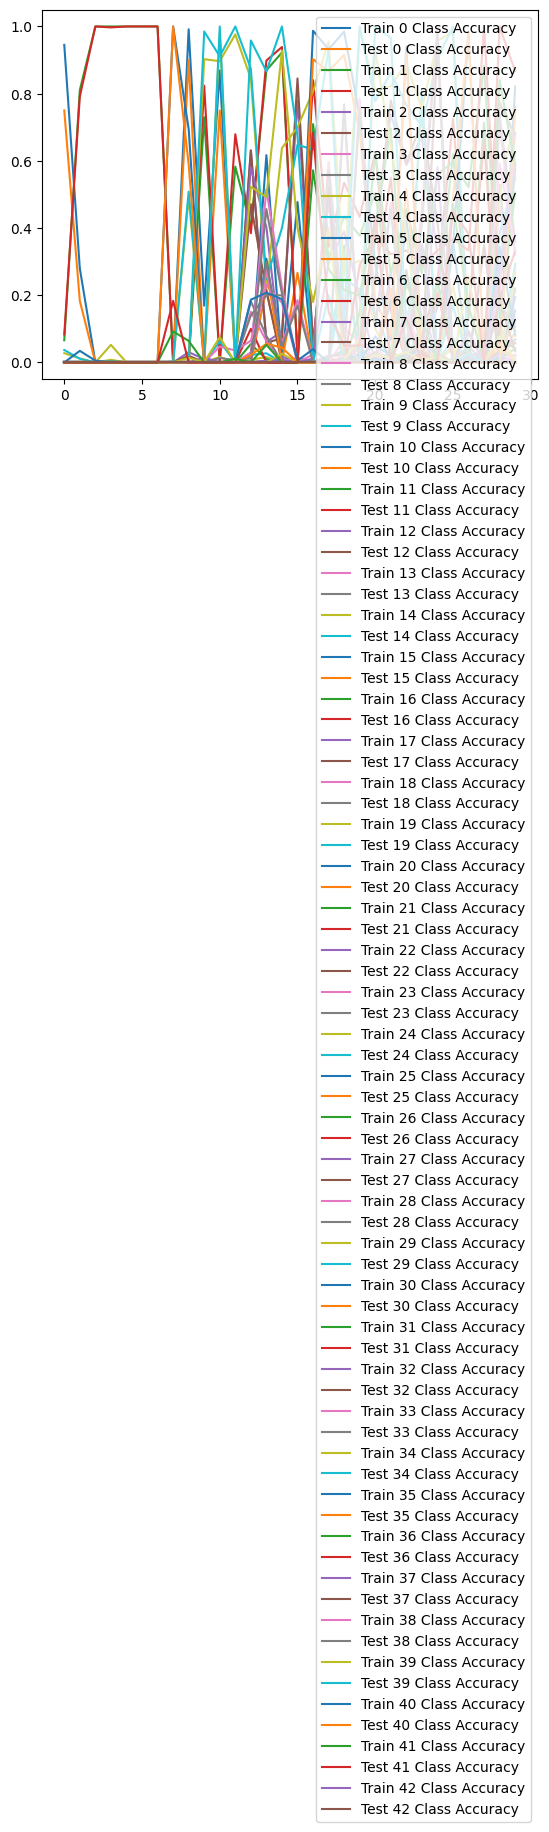

In [30]:
import numpy as np
import pandas as pd
import pickle
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils.class_weight import compute_class_weight
# from datasets_preparing import load_rgb_data
from keras.utils.np_utils import to_categorical
import pdb

path = os.getcwd() # 현재 디렉토리 선언
data = pd.read_pickle(path + '\\data0.pickle')
# pdb.set_trace()

# sign=pd.DataFrame.from_dict(data,orient='index')
# sign.loc[['x_train','x_test','y_train','y_test'],:]

x_train = data['x_train'] / 255.0
x_test = data['x_test'] / 255.0
t_train = data['y_train']
t_test = data['y_test']

# print(x_test) # (86989, 3072)
# print(t_train.shape) # (86989, 43)
# print(x_test.shape) # (12630, 3072)
# print(t_test.shape) # (12630, 43)

train_data = pd.read_pickle(path + '\\train.pickle')
train_labels = train_data['labels']
from collections import Counter 
# 리스트 안에 요소별로 개수를 확인하는 방법
counted = Counter(train_labels) # 라벨별로 개수를 세어줌
print('label별 개수: ',counted) # 라벨별 개수 출력

# # 모델 입력 크기와 일치하도록 데이터 크기 수정
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)


# 히든노드 크기
network = TwoLayerNet(input_size=3072, hidden_size=500, output_size=43)

# 하이퍼 파라미터
iters_num = 30
train_size = x_train.shape[0]
batch_size = 500
learning_rate = 0.4

train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_num = [] # 추가된 부분
class_train_acc_list = []
class_test_acc_list = []


# 1에폭 당 반복수
iter_per_epoch = max(train_size / batch_size, 1)

# 데이터 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(t_train), y=t_train)
data_weights = class_weights[t_train]

for i in range(iters_num):
    #미니 배치
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    data_weights_batch = data_weights[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
        # 가중치 반영
    class_batch = t_batch  # 클래스 레이블
    class_learning_rate = np.array([class_weights[c] for c in class_batch])  # 클래스별 러닝 레이트
    grad['W2'] *= np.expand_dims(data_weights_batch * class_learning_rate, axis=1)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    # 학습경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    # 1에폭 당 정확도 계산
    train_acc, class_train_acc = network.accuracy(x_train, t_train)
    test_acc, class_test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    iter_num.append(i)
    class_train_acc_list.append(class_train_acc)
    class_test_acc_list.append(class_test_acc)

    
    print(i,train_acc, test_acc)
        
import matplotlib.pyplot as plt
plt.plot(iter_num, train_acc_list, label="train")
plt.plot(iter_num, test_acc_list, label="test")
plt.legend()
plt.show()

class_train_acc = np.array(class_train_acc_list)
class_test_acc = np.array(class_test_acc_list)
class_train_reshape_list = class_train_acc.T
class_test_reshape_list = class_test_acc.T

for i in range(np.max(t_train)+1):
    plt.plot(iter_num, class_train_reshape_list[i], label="Train %d Class Accuracy" % (i))
    plt.plot(iter_num, class_test_reshape_list[i], label="Test %d Class Accuracy"% (i))
    
plt.legend()
plt.show()

label별 개수:  Counter({2: 2010, 1: 1980, 13: 1920, 12: 1890, 38: 1860, 10: 1800, 4: 1770, 5: 1650, 25: 1350, 9: 1320, 7: 1290, 3: 1260, 8: 1260, 11: 1170, 35: 1080, 18: 1080, 17: 990, 31: 690, 14: 690, 33: 599, 26: 540, 15: 540, 28: 480, 23: 450, 30: 390, 16: 360, 34: 360, 6: 360, 36: 330, 22: 330, 40: 300, 20: 300, 39: 270, 21: 270, 29: 240, 24: 240, 41: 210, 42: 210, 32: 210, 27: 210, 37: 180, 19: 180, 0: 180})
Epoch   1 | Loss 3.7533 | Train Acc 0.0331 | Test Acc 0.0215
Epoch   2 | Loss 3.7496 | Train Acc 0.0423 | Test Acc 0.0549
Epoch   3 | Loss 3.7451 | Train Acc 0.0355 | Test Acc 0.0490
Epoch   4 | Loss 3.7416 | Train Acc 0.0395 | Test Acc 0.0605
Epoch   5 | Loss 3.7390 | Train Acc 0.0393 | Test Acc 0.0738
Epoch   6 | Loss 3.7332 | Train Acc 0.0378 | Test Acc 0.0678
Epoch   7 | Loss 3.7286 | Train Acc 0.0404 | Test Acc 0.0808
Epoch   8 | Loss 3.7236 | Train Acc 0.0399 | Test Acc 0.0800
Epoch   9 | Loss 3.7167 | Train Acc 0.0293 | Test Acc 0.0631
Epoch  10 | Loss 3.7160 | Train Acc 

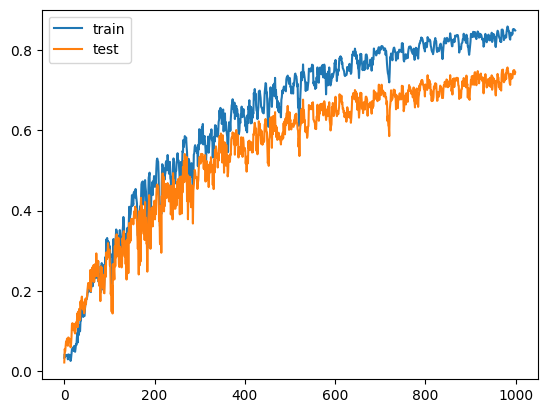

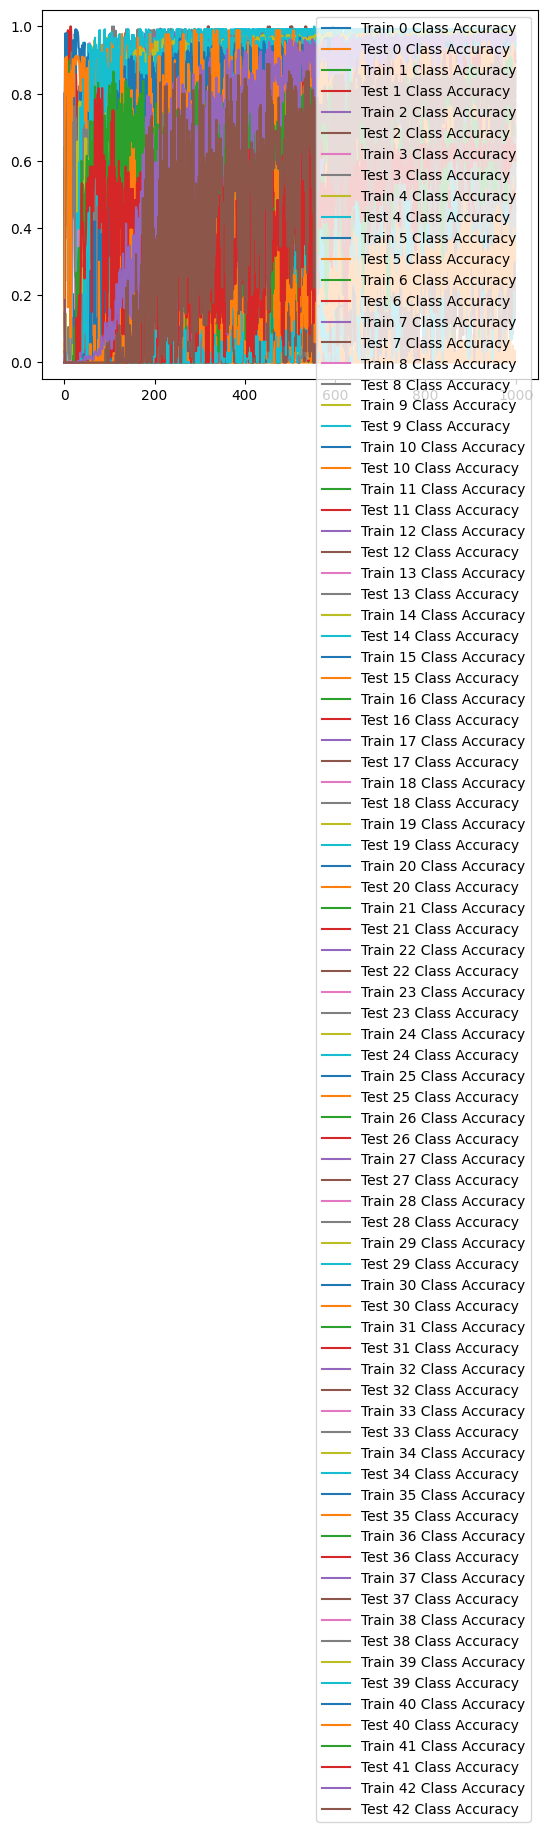

In [33]:
import numpy as np
import pandas as pd
import pickle
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils.class_weight import compute_class_weight
# from datasets_preparing import load_rgb_data
from keras.utils.np_utils import to_categorical
import pdb

path = os.getcwd() # 현재 디렉토리 선언
data = pd.read_pickle(path + '\\data0.pickle')
# pdb.set_trace()

# sign=pd.DataFrame.from_dict(data,orient='index')
# sign.loc[['x_train','x_test','y_train','y_test'],:]

x_train = data['x_train'] / 255.0
x_test = data['x_test'] / 255.0
t_train = data['y_train']
t_test = data['y_test']

# print(x_test) # (86989, 3072)
# print(t_train.shape) # (86989, 43)
# print(x_test.shape) # (12630, 3072)
# print(t_test.shape) # (12630, 43)

train_data = pd.read_pickle(path + '\\train.pickle')
train_labels = train_data['labels']
from collections import Counter 
# 리스트 안에 요소별로 개수를 확인하는 방법
counted = Counter(train_labels) # 라벨별로 개수를 세어줌
print('label별 개수: ',counted) # 라벨별 개수 출력

# # 모델 입력 크기와 일치하도록 데이터 크기 수정
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)


# 히든노드 크기
network = TwoLayerNet(input_size=3072, hidden_size=500, output_size=43)

# 하이퍼 파라미터
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 3000
learning_rate = 0.2

train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_num = [] # 추가된 부분
class_train_acc_list = []
class_test_acc_list = []
train_geometric_list = []
test_geometric_list = []

# 1에폭 당 반복수
iter_per_epoch = max(train_size / batch_size, 1)

# 데이터 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(t_train), y=t_train)
min_weight = np.min(class_weights)
class_weights /= min_weight

for i in range(iters_num):
    #미니 배치
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
        # 가중치 반영
    class_learning_rate = np.reshape(class_weights, (1, -1))  # 클래스별 러닝 레이트
    grad['W2'] *= class_learning_rate
        
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭 당 정확도 계산
    train_acc, class_train_acc = network.accuracy(x_train, t_train)
    test_acc, class_test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    iter_num.append(i)
    class_train_acc_list.append(class_train_acc)
    class_test_acc_list.append(class_test_acc)
    
    geometric_train = np.prod(class_train_acc) ** (1 / len(class_train_acc))
    geometric_test = np.prod(class_test_acc) ** (1 / len(class_test_acc))

    train_geometric_list.append(geometric_train)
    test_geometric_list.append(geometric_test)

    print('Epoch %3d | Loss %.4f | Train Acc %.4f | Test Acc %.4f' % (i + 1, loss, train_acc, test_acc))
    
import matplotlib.pyplot as plt

plt.plot(iter_num, train_acc_list, label="train")
plt.plot(iter_num, test_acc_list, label="test")
plt.legend()
plt.show()

class_train_acc = np.array(class_train_acc_list)
class_test_acc = np.array(class_test_acc_list)
class_train_reshape_list = class_train_acc.T
class_test_reshape_list = class_test_acc.T

for i in range(np.max(t_train)+1):
    plt.plot(iter_num, class_train_reshape_list[i], label="Train %d Class Accuracy" % (i))
    plt.plot(iter_num, class_test_reshape_list[i], label="Test %d Class Accuracy"% (i))

plt.legend()
plt.show()

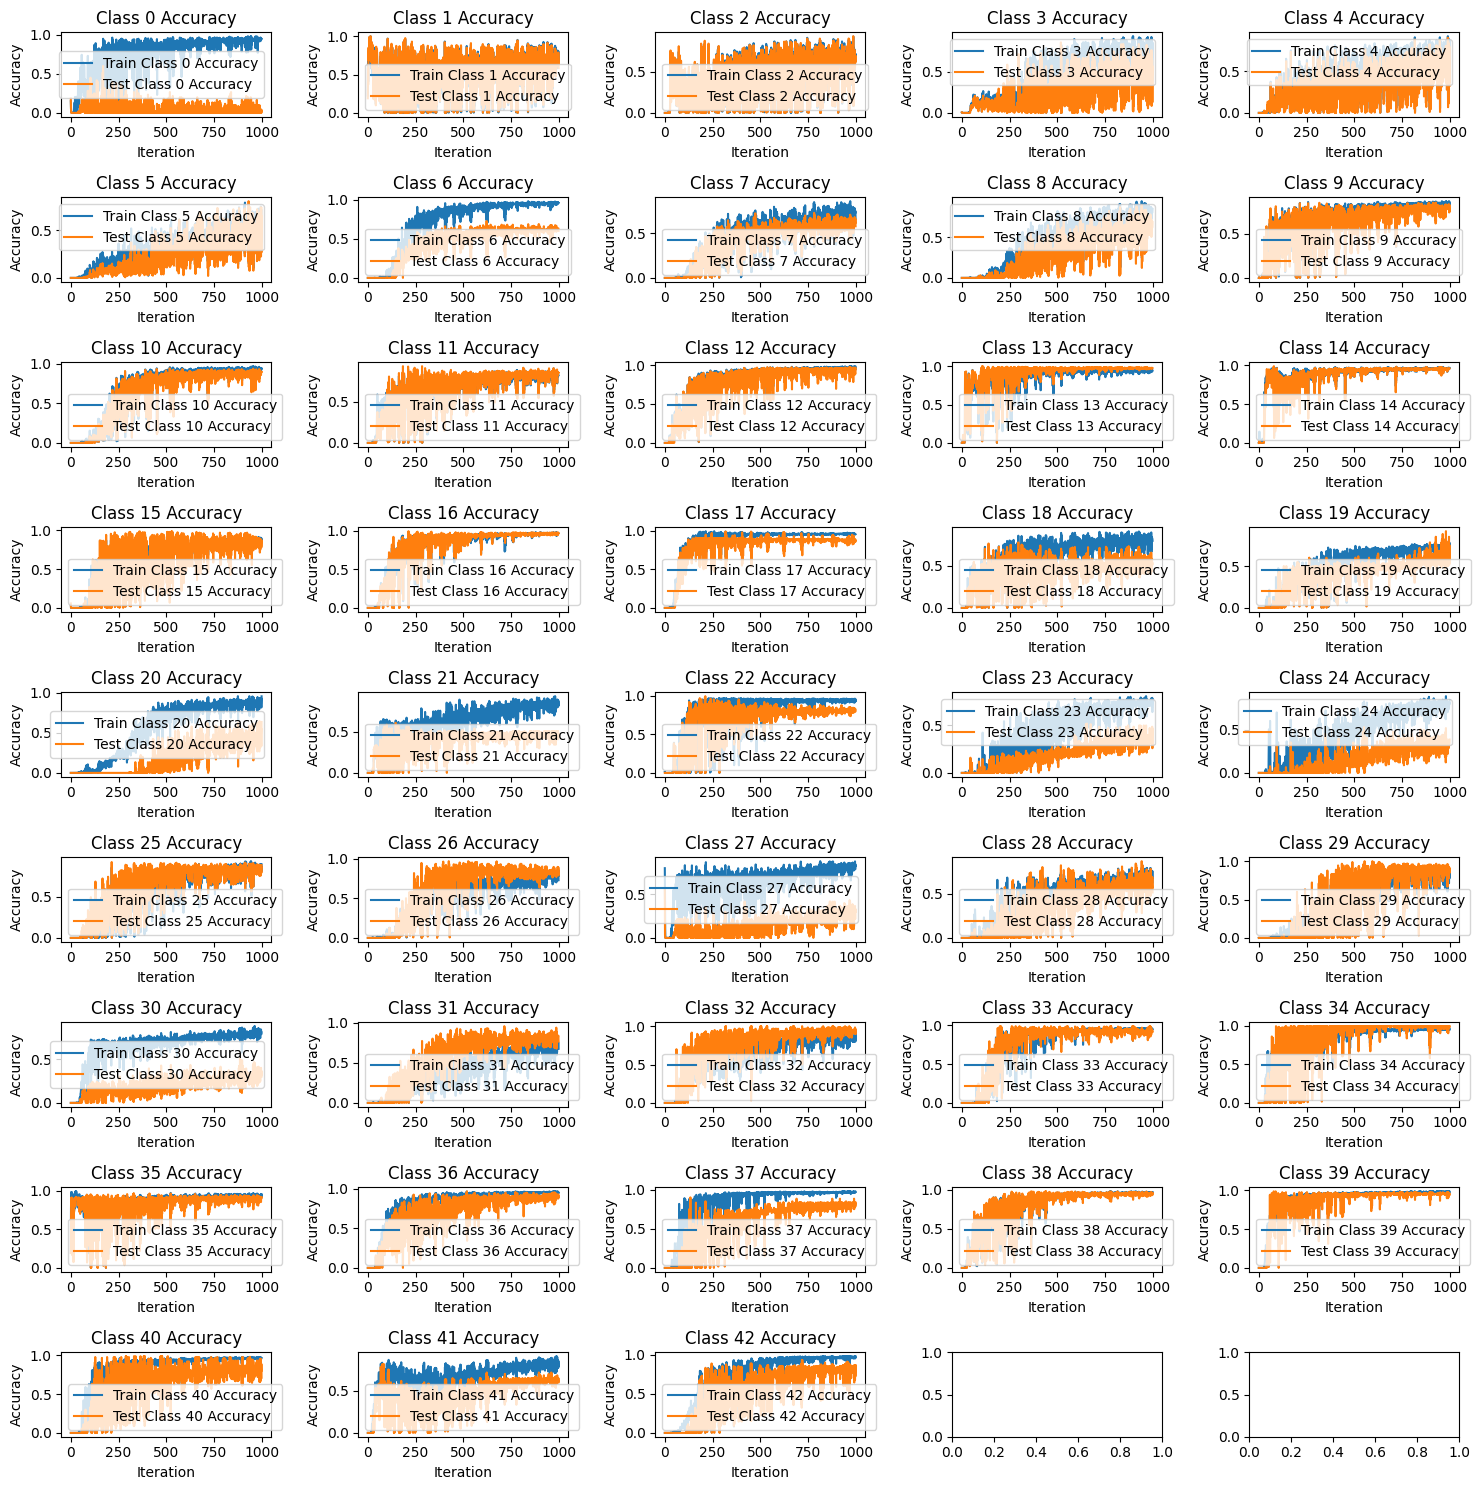

In [48]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(9, 5, figsize=(15, 15))

for i in range(np.max(t_train) + 1):
    row = i // 5
    col = i % 5

    axes[row, col].plot(iter_num, class_train_reshape_list[i], label="Train Class %d Accuracy" % (i))
    axes[row, col].plot(iter_num, class_test_reshape_list[i], label="Test Class %d Accuracy" % (i))
    axes[row, col].legend()
    axes[row, col].set_title("Class %d Accuracy" % (i))
    axes[row, col].set_xlabel("Iteration")
    axes[row, col].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()



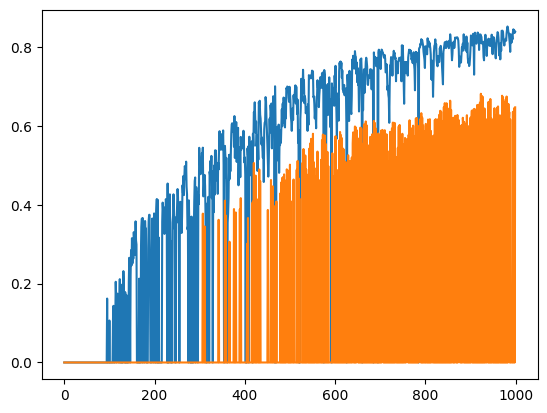

In [45]:


plt.plot(iter_num, train_geometric_list, label="Train geometric mean")
plt.plot(iter_num, test_geometric_list, label="Test geometric mean")

plt.show()

In [47]:
test_geometric_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [43]:
train_geometric_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.16212561736275963,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10644576787272415,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.11109913490885977,
 0.14365747525485537,
 0.0,
 0.0,
 0.0,
 0.11057660887313647,
 0.2046943345808728,
 0.16217372177624845,
 0.0,
 0.11907907486991828,
 0.1745889034332931,
 0.14653200501009228,
 0.16661130449723463,
 0.0,
 0.13758320577809732,
 0.2113103078267001,
 0.0,
 0.0,
 0.0,
 0.136580142793066,
 0.0,
 0.1984

In [36]:
class_train_acc

array([[0.14928324, 0.22639644, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05585764, 0.64211567, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01828967, 0.40731587, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.94710826, 0.66386555, 0.72219476, ..., 0.96243203, 0.77014335,
        0.97775581],
       [0.93969352, 0.80326248, 0.6752348 , ..., 0.96589224, 0.85417696,
        0.95650025],
       [0.94760257, 0.63766683, 0.71428571, ..., 0.96539792, 0.79189323,
        0.97923875]])